Assume that you are hired by the Transport for London (TfL). TfL manages the 
London's buses, London Underground, Docklands Light Railway, London Overground 
and London Trams. Your first task is to create a transport alert system exploiting 
Twitter data. It is assumed that there are enough social media data discussing 
transport related issues. Given this context, answer the following questions.

In [1]:
from math import radians, sqrt, sin, cos, atan2, trunc, ceil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import re

(i) A data set will be given to you (In the Data folder teams). Develop software to organise 
tweets into grids of 1km x 1km. Draw charts or figures to analyse the distribution of 
data.
The coordinate system we used is 
London = [-0.563, 51.261318, 0.28036, 51.686031]

In [2]:
# Haversine distance

def haverSine(lat1,lon1,lat2,lon2):

    R = 6371e3
    lat1 = lat1
    lat2 = lat2
    lon1 = lon1
    lon2 = lon2

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    alon = lon2 - lon1
    alat = lat2 - lat1

    a = sin(alat/2)**2 + cos(lat1) * cos(lat2) * sin(alon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c

    return d

In [3]:
data_df = pd.read_json('Data\geoLondonAug2020-1', lines=True)

#London = [51.261318, -0.563, 51.686031, 0.28036] # lat long
lower_lat = 51.261318
lower_long = -0.563
higher_lat = 51.686031
higher_long = 0.28036
dist_London = haverSine(lower_lat, lower_long, higher_lat, higher_long)
print("Distance from providing coordinate data:", round(dist_London/1000,2), "km")

# get twitter coordinate
twi_co = data_df['coordinates']
co_list = list()
for i in twi_co:
    co_list.append(i['coordinates']) # [0]long [1]lat
co_array = np.asarray(co_list)

Distance from providing coordinate data: 75.11 km


In [20]:
print("diagonal = sqrt( width**2 + length**2 )")
print("~75km = sqrt (48**2 + 59**2 )")
print(round(sqrt(47**2 + 59**2 )))
print("Grid with 1x1km length will has Row: 48 and Col: 49")

diagonal = sqrt( width**2 + length**2 )
~75km = sqrt (48**2 + 59**2 )
75
Grid with 1x1km length will has Row: 48 and Col: 49


In [25]:
# Find verticle and horizontal offset of grid number

# point[1],point[0] lat lon

#higher_lat = 51.686031
#higher_long = 0.28036

verticle_offset = haverSine(51.261318, -0.563, 51.686031, -0.563)
row = round(verticle_offset/1000)
#print(round(verticle_offset/1000))

horizontal_offset = haverSine(51.261318, -0.563, 51.261318, 0.28036)
col = round(horizontal_offset/1000)
#print(round(horizontal_offset/1000))

print('Row: '+ str(row) + ' Col: ' + str(col))

Row: 47 Col: 59


In [26]:
# set row and column
london_grid = np.zeros(row*col)

for point in co_array:
    # use haverSine to calculate offset of from lat and long
    verticle_offset = haverSine(lower_lat, lower_long, point[1], lower_long)
    horizontal_offset = haverSine(lower_lat, lower_long, lower_lat, point[0])

    # assign grid number
    grid_number = ( round(verticle_offset/1000) * col + round(horizontal_offset/1000) )

    # count the amount of tweets
    if(grid_number <= row * col):
        london_grid[grid_number-1] += 1
    else:
        print(grid_number)

In [27]:
# Testing haversine and london grid
verticle_offset = haverSine(lower_lat, lower_long, higher_lat, lower_long)
horizontal_offset = haverSine(lower_lat, lower_long, lower_lat, higher_long)
grid_number = ( round(verticle_offset/1000) * col + round(horizontal_offset/1000) )
grid_number

#print(np.max(london_grid), np.argmax(london_grid))

2832

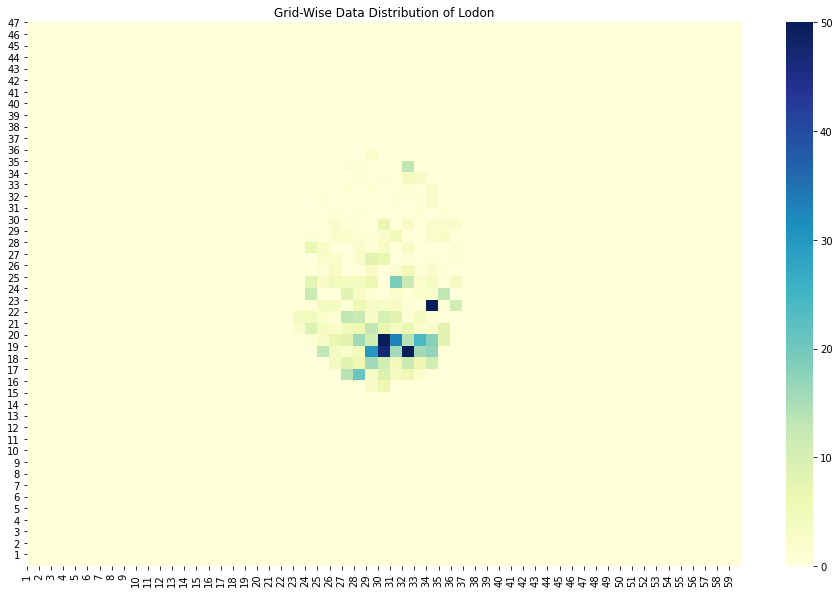

In [28]:
# use heatmap to display amount of tweets based on location into grid
heatmap_london = london_grid.reshape(row, col)

fig, ax = plt.subplots(figsize=(16,10))
ax = sns.heatmap(ax=ax, data=heatmap_london, cmap="YlGnBu", vmax=50)

ax.set_yticks(range((row)))
ax.set_yticklabels([i for i in range(row,0,-1)])

ax.set_xticks(range((col)))
ax.set_xticklabels([i for i in range(1,col+1)])

plt.title("Grid-Wise Data Distribution of Lodon")
plt.show()

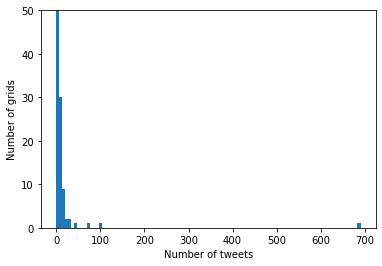

In [29]:
plt.hist(london_grid, 100,
         histtype ='bar')
plt.ylim(0, 50) 
plt.xlabel("Number of tweets")
plt.ylabel("Number of grids")
plt.show()

(ii) If you were to use a grid-based system, identify the potential biases you may 
encounter and how are you going to address them?

<b>Answer</b> The potential biases that may encounter is Geographical bias. Use voting algorithms to address this bias.

(iii) Majority of the data collected from an area/region is non-geo tagged. How do you test 
the effectiveness of the model for non-geo tagged data set? 

<b>Answer</b> To test the effectiveness of the model is use evaluation method by ignore actual location, then use model to predict location by looking at the content of tweets or geo-graphical characteristics and compare with actual location. When compare distance between predict and actual location, the measurement will use average error distance, accuracy of location in 3 km radisu, and recall.

In [47]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("http://dbpedia.org/sparql")

sparql.setQuery("""
    PREFIX dbpedia: <http://dbpedia.org/resource/> 
    PREFIX dbpedia-owl: <http://dbpedia.org/ontology/> 
    
    SELECT *
    WHERE { 
        ?s dbpedia-owl:city  <http://dbpedia.org/resource/London> .
        ?s geo:lat ?lat .
        ?s geo:long ?long .
    }
""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

london_loc_list = list()

# Store every london location lat and long from dbpedia website
for result in results["results"]["bindings"]:
    
    loc = result["s"]["value"].replace("http://dbpedia.org/resource/","").replace("_", " ")
    lat = result["lat"]["value"]
    long = result["long"]["value"]
    london_loc_list.append([loc, lat, long])
london_loc = np.asarray(london_loc_list)

In [32]:
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

all_stopwords = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

#Tokenize
def spacy_tokenize(string):
    tokens = list()
    doc = nlp(string)
    for token in doc:
        if(not token.text in all_stopwords): # Remove stop words in token process
            tokens.append(token)
    return tokens

#Normalize
def normalize(tokens):
    normalized_tokens = list()
    for token in tokens:
        normalized = token.text.lower().strip()
        if ((token.is_alpha or token.is_digit)):
            normalized_tokens.append(normalized)
    return normalized_tokens

#Tokenize and normalize
def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [33]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data_df, test_size = 0.3)

In [34]:
train_set.head(5)

,_id,date,username,text,geoenabled,coordinates,location,place_name,place_country,country_code,place_coordinates,hashtags,mentions,source
1051,1289676729716416512,{'$date': '2020-08-01T21:37:48Z'},AdonisOHoli,#poetry\n#album\n#mynakedness\n#adonisoholi\n#...,True,"{'type': 'Point', 'coordinates': [-0.109400000...",East London,"City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...","[poetry, album, mynakedness, adonisoholi, whod...",[],Instagram
861,1289618957842804736,{'$date': '2020-08-01T17:48:14Z'},MilesLanham,The first #tomatoes of my terrace this year!! ...,True,"{'type': 'Point', 'coordinates': [-0.11291941,...",Lambeth North,"Lambeth, London",United Kingdom,GB,"[[[-0.15191000000000002, 51.410792], [-0.07890...","[tomatoes, plantdaddy]",[],Instagram
668,1289564006802481152,{'$date': '2020-08-01T14:09:52Z'},VeganVenues,New #veganvenues added on our site!\nSupport y...,True,"{'type': 'Point', 'coordinates': [-0.109400000...",Earth Realm,"City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...",[veganvenues],[],Instagram
1377,1289879259784216576,{'$date': '2020-08-02T11:02:34Z'},tmj_lon_retail,"Career tip for landing jobs like ""Shift Superv...",True,"{'type': 'Point', 'coordinates': [-0.1932417, ...",London,"Wandsworth, London",United Kingdom,GB,"[[[-0.259465, 51.417277], [-0.127974, 51.41727...",[Retail],[],CareerArc 2.0
998,1289656439514886144,{'$date': '2020-08-01T20:17:10Z'},marston7,And that is that!! Gooners record breaking @ L...,True,"{'type': 'Point', 'coordinates': [-0.109400000...",london,"City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...",[],[],Instagram


In [35]:
# Geo-localisation based on tweets text information

def nearlocation(train_set):
    # Remove hyperlink
    remove_link = re.sub(r'http\S+', '', train_set)
    text_norm = tokenize_normalize(remove_link)
    # Remove short text and london text
    text_norm = [tex for tex in text_norm if len(tex) > 4 and tex != 'london']
    max_counter = 10
    selected_text = ""
    selected_loc = ""
    for txt in text_norm:
        text_counter = 0
        for loc in london_loc:
            if(re.search(txt, loc[0].lower())):
                text_counter += 1
            
        if(text_counter < max_counter and text_counter != 0):
            max_counter = text_counter
            selected_text = txt
            
    for loc in london_loc:
        if(re.search(selected_text, loc[0].lower())):
            selected_loc = [loc[0], loc[1], loc[2]]
            break;
    if(selected_text == ""):
        return None
    else:      
        return [selected_loc[1],selected_loc[2]]

In [36]:
# Geo-localisation based on place_name tag

def applyOtherloc(train_set):
    for index, row in train_set.iterrows():
        if(row['predict_coordinates'] is None):
            place_list = row['place_name'].split(",")
            place_count = 0
            lat_long = ""
            for loc in london_loc:
                if(re.search(place_list[0].lower(), loc[0].lower())):
                    place_count += 1
                    lat_long = [loc[1], loc[2]]

            # If there are multiple result then use location tag to specific       
            if(place_count == 0 or place_count > 1):
                loc_list = row['location'].split(",")
                loc_count = 0
                for loc in london_loc:
                    if(re.search(loc_list[0].lower(), loc[0].lower())):
                        loc_count += 1
                        train_set.at[index,'predict_coordinates'] = [loc[1], loc[2]]
                        break;
                        
                # Geo-localised tweets that can't identify from context or location
                if(loc_count == 0):
                    for loc in london_loc:
                        if(re.search("London".lower(), loc[0].lower())):
                            train_set.at[index,'predict_coordinates'] = [loc[1], loc[2]]
                            break;
            else:
                train_set.at[index,'predict_coordinates'] = lat_long

In [450]:
train_set['predict_coordinates'] = train_set['text'].apply(nearlocation)
applyOtherloc(train_set)

<ipython-input-450-f71c0f35fe62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['predict_coordinates'] = train_set['text'].apply(nearlocation)


In [451]:
train_set.head(5)

,_id,date,username,text,geoenabled,coordinates,location,place_name,place_country,country_code,place_coordinates,hashtags,mentions,source,predict_coordinates
584,1289542357038194688,{'$date': '2020-08-01T12:43:51Z'},AljacobRds,#wearamask #youfukkinpussy #justtellidiots #it...,True,"{'type': 'Point', 'coordinates': [-0.109400000...","London, England","City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...","[wearamask, youfukkinpussy, justtellidiots, it...",[],Instagram,"[51.5116, -0.11975]"
250,1289462043272048642,{'$date': '2020-08-01T07:24:42Z'},mummyconstant,August is here! Here are the photo prompts for...,True,"{'type': 'Point', 'coordinates': [-0.11666667,...","St Neots, Cambridgeshire","Lambeth, London",United Kingdom,GB,"[[[-0.15191000000000002, 51.410792], [-0.07890...",[mummyphotoaday],[],Instagram,"[51.4586, -0.14098]"
1037,1289670074995863553,{'$date': '2020-08-01T21:11:21Z'},rjmorgan2,We were able to watch an absolutely stunning c...,True,"{'type': 'Point', 'coordinates': [-0.09612664,...",,"City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...","[voces8, livefromlondon]",[VOCES8],Instagram,"[51.4723, -0.2465]"
45,1289300319961112576,{'$date': '2020-07-31T20:42:04Z'},KemiTaiwoPoet,I am super excited to share this piece for the...,True,"{'type': 'Point', 'coordinates': [-0.109400000...",Web,"City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...",[selfcaresummercollab],[],Instagram,"[51.5116, -0.11975]"
474,1289515513354153984,{'$date': '2020-08-01T10:57:11Z'},DraftHouseNC,Weekend is here!! ️\n\n#weekendvibes #drafthou...,True,"{'type': 'Point', 'coordinates': [-0.165990000...","Battersea, Clapham Junction","Wandsworth, London",United Kingdom,GB,"[[[-0.259465, 51.417277], [-0.127974, 51.41727...","[weekendvibes, drafthouse, northcote, cocktail...",[DraftHouseUK],Instagram,"[51.5661, -0.27411]"


In [452]:
test_set.head(5)

,_id,date,username,text,geoenabled,coordinates,location,place_name,place_country,country_code,place_coordinates,hashtags,mentions,source
539,1289530912695230466,{'$date': '2020-08-01T11:58:22Z'},thejackheard,Save Our Southbank! #CrisisInCulture #SaveOurS...,True,"{'type': 'Point', 'coordinates': [-0.11677265,...",,"Lambeth, London",United Kingdom,GB,"[[[-0.15191000000000002, 51.410792], [-0.07890...","[CrisisInCulture, SaveOurSouthbank]",[],Instagram
1362,1289874849217892352,{'$date': '2020-08-02T10:45:03Z'},prince_darien,"Just posted a photo @ London, United Kingdom h...",True,"{'type': 'Point', 'coordinates': [-0.109400000...","London, England, UK","City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...",[],[],Instagram
157,1289347928633597952,{'$date': '2020-07-31T23:51:15Z'},trafficgifs,A5 Edgware Road at Cuthbert Street https://t.c...,True,"{'type': 'Point', 'coordinates': [-0.17438, 51...","New York, NY","Paddington, London",United Kingdom,GB,"[[[-0.2160701, 51.5098789], [-0.1301597, 51.50...",[],[],everybot
680,1289567344583467008,{'$date': '2020-08-01T14:23:08Z'},Jaybrownvsm73,I don’t need to act my age .... I know where I...,True,"{'type': 'Point', 'coordinates': [-0.109400000...","London, England","City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...","[skaterboy, trucks, photography]","[captureyephotog, roguemodelsuk]",Instagram
1377,1289879259784216576,{'$date': '2020-08-02T11:02:34Z'},tmj_lon_retail,"Career tip for landing jobs like ""Shift Superv...",True,"{'type': 'Point', 'coordinates': [-0.1932417, ...",London,"Wandsworth, London",United Kingdom,GB,"[[[-0.259465, 51.417277], [-0.127974, 51.41727...",[Retail],[],CareerArc 2.0


In [38]:
test_set['predict_coordinates'] = test_set['text'].apply(nearlocation)
applyOtherloc(test_set)


<ipython-input-38-a657a4d0bfef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['predict_coordinates'] = test_set['text'].apply(nearlocation)


In [39]:
test_set.head(5)

,_id,date,username,text,geoenabled,coordinates,location,place_name,place_country,country_code,place_coordinates,hashtags,mentions,source,predict_coordinates
63,1289305106702163969,{'$date': '2020-07-31T21:01:06Z'},Jaybrownvsm73,If you ever loose your way ...And everything i...,True,"{'type': 'Point', 'coordinates': [-0.1280728, ...","London, England","London, England",United Kingdom,GB,"[[[-0.18789399999999998, 51.483718], [-0.10997...","[photography, bandana]",[captureyephotog],Instagram,"[51.5038, -0.0148581]"
1422,1289894711168135168,{'$date': '2020-08-02T12:03:58Z'},cooking_fiend,Lovely day out in #london today. It’s sooo qui...,True,"{'type': 'Point', 'coordinates': [-0.07524401,...","Kingston upon Thames, London","Poplar, London",United Kingdom,GB,"[[[-0.080028, 51.48432], [0.009989, 51.48432],...","[london, adventure, towerbridge, stkatherinesd...",[],Instagram,"[51.4092, -0.306458]"
1136,1289789059036921856,{'$date': '2020-08-02T05:04:09Z'},Nayanmitra,Nayanmitra’s Aum for renewal and rejuvenation ...,True,"{'type': 'Point', 'coordinates': [-0.109400000...",London,"City of London, London",United Kingdom,GB,"[[[-0.112442, 51.5068], [-0.0733794, 51.5068],...","[meditation, spirituality, painting, artwork, ...",[],Instagram,"[51.5178, -0.116389]"
1436,1289896717731725312,{'$date': '2020-08-02T12:11:57Z'},DanciaLondon,Time for new Pointe Shoes? \nWill it be your f...,True,"{'type': 'Point', 'coordinates': [-0.123010000...","London, England","Camden Town, London",United Kingdom,GB,"[[[-0.213503, 51.512805], [-0.105303, 51.51280...",[],[],Instagram,"[51.5238, -0.2927]"
1127,1289768167279955968,{'$date': '2020-08-02T03:41:08Z'},dominicsg,[2 August 2020 ] #France’s longest border is s...,True,"{'type': 'Point', 'coordinates': [-0.1890134, ...","Paddington, London","Paddington, London",United Kingdom,GB,"[[[-0.2160701, 51.5098789], [-0.1301597, 51.50...","[France, Brazil, FrenchGuiana, フランス, ヨーロッパ, 仏領...",[],Instagram,"[51.5238, -0.2927]"


In [45]:
# Measures of Average Error distance / Accuracy / Recall  
# between actual location and predicted location

total_error_distance = 0
accuracy = 0
recall = 0
for index, row in test_set.iterrows():
    if(row['predict_coordinates'] is not None):
        distance_place = haverSine(row['coordinates']['coordinates'][1],
                                   row['coordinates']['coordinates'][0], 
                                   float(row['predict_coordinates'][0]),
                                   float(row['predict_coordinates'][1]))

        distance_loc = round(distance_place/1000)
        if(distance_loc <= 3):
            accuracy += 1  
        total_error_distance += distance_loc
        recall += 1
print("Average Error Distance:", round(total_error_distance/len(test_set),2), "Km")
print("Accuracy of predicted location within 3 Km:", round(accuracy/len(test_set),2) * 100, "%")
print("Recall of tweets with geo-localised:", round(recall/len(test_set), 2)*100, "%")

Average Error Distance: 11.72 Km
Accuracy of predicted location within 3 Km: 53.0 %
Recall of tweets with geo-localised: 100.0 %
